# Packages

In [1]:
# data processing
import scanpy as sc
import muon as mu
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os

# Loading

In [ ]:
data_path = 'path/to/data/'

path_10x = f'{data_path}10x_out/' # subfolder containing all .h5 files from CellRanger

Datasets are loaded the muon read_10x_h5 function to automatically create a MuData object which contains an AnnData object for the RNA counts and one for the Hashtag counts for demultiplexing.

In [3]:
all_datasets_names = [f for f in os.listdir(path_10x) if f.endswith('.h5')]

all_datasets = {f.split('.')[0]: mu.read_10x_h5(f'{path_10x}{f}') for f in all_datasets_names}

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/mudata/_core/mudata.py:477: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata

# Demultiplexing

Since the hashing IDs were different in the some datasets compared to others, we have to demultiplex using 2 lists of hashtags.

In [4]:
hto_list = [f'Hashtag_{i}' for i in range(1,7)]
hto_list_old = [f'HASH_{i}' for i in range(11, 17)]

Some logic is included to make sure the right hashtag lists are used for the right datasets.

In [5]:
for ds in all_datasets:
    print(f'Processing {ds}')
    if ds.startswith('spf') and not ds.endswith('e185') and not ds.endswith('p90'):
        for hto in hto_list_old:
            all_datasets[ds]['rna'].obs[hto] = all_datasets[ds]['prot'][:,all_datasets[ds]['prot'].var_names == hto].X.toarray()
        
        sc.external.pp.hashsolo(all_datasets[ds]['rna'], hto_list_old)
    else:
        for hto in hto_list:
            all_datasets[ds]['rna'].obs[hto] = all_datasets[ds]['prot'][:,all_datasets[ds]['prot'].var_names == hto].X.toarray()
        
        sc.external.pp.hashsolo(all_datasets[ds]['rna'], hto_list)

    all_datasets[ds] = all_datasets[ds]['rna']

Processing wildling_p60
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing germfree_p7
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing wildling_p1
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing spf_e185
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing spf_p21
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing germfree_p90
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing spf_p1
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing spf_p90
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Processing spf_p7
Please cite HashSolo paper:
https://www.cell.com/cell-systems/fullte

# Filtering and Metadata

A copy of the datasets before filtering is kept for plotting at the end.

In [6]:
all_datasets_unfiltered = all_datasets.copy()

Cells containing <500 counts or <200 genes or >10% mitochondrial counts are removed as low quality. If cells were classified as doublets or negative during demultiplexing are also removed. \
Genes that are expressed in fewer than 3 cells are also removed. Ribosomal, mitochondrial and genes with the Gm identifier are also removed as they are not of interest or relevant.

In [7]:
for ds in all_datasets:
    
    all_datasets[ds].obs = all_datasets[ds].obs[['Classification']]

    if ds == 'wildling_spf_p100':
        all_datasets[ds].obs['microbiota_status'] = np.where(all_datasets[ds].obs['Classification'].str.contains(r'(1|2|3)', regex=True), 'wildling', 'spf')
        all_datasets[ds].obs['timepoint'] = ds.split('_')[2]
    else:
        all_datasets[ds].obs['microbiota_status'] = ds.split('_')[0]
        all_datasets[ds].obs['timepoint'] = ds.split('_')[1]

    all_datasets[ds].obs['batch'] = ds

    all_datasets[ds].var_names_make_unique()
    all_datasets[ds].var['mt'] = all_datasets[ds].var_names.str.startswith('mt-')

    sc.pp.calculate_qc_metrics(all_datasets[ds], qc_vars=['mt'], inplace=True)

    sc.pp.filter_cells(all_datasets[ds], min_counts=500)
    sc.pp.filter_cells(all_datasets[ds], min_genes=200)
    sc.pp.filter_genes(all_datasets[ds], min_cells=3)

    all_datasets[ds].var['ribo'] = all_datasets[ds].var_names.str.contains(r'^Rp[l|s]\d+', regex=True)
    all_datasets[ds].var['gm'] = all_datasets[ds].var_names.str.contains(r'^Gm\d+', regex=True)

    all_datasets[ds] = all_datasets[ds][all_datasets[ds].obs['pct_counts_mt'] <= 10]
    all_datasets[ds] = all_datasets[ds][~all_datasets[ds].obs['Classification'].isin(['Doublet', 'Negative']), ~(all_datasets[ds].var['ribo']) & ~(all_datasets[ds].var['gm']) & ~(all_datasets[ds].var['mt'])]

    if ds.startswith('spf'):
        all_datasets[ds] = all_datasets[ds][all_datasets[ds].obs['Classification'].str.endswith(('1', '2', '3'))]

    all_datasets[ds].obs['replicate'] = np.nan

    all_datasets[ds].obs.loc[
        all_datasets[ds].obs['Classification'].str.endswith(('1', '4')),
        'replicate'
    ] = (
        all_datasets[ds].obs['microbiota_status'] + 
        '_' + 
        all_datasets[ds].obs['timepoint'] + 
        '_' + '1'
    )

    all_datasets[ds].obs.loc[
        all_datasets[ds].obs['Classification'].str.endswith(('2', '5')),
        'replicate'
    ] = (
        all_datasets[ds].obs['microbiota_status'] + 
        '_' + 
        all_datasets[ds].obs['timepoint'] + 
        '_' + '2'
    )

    all_datasets[ds].obs.loc[
        all_datasets[ds].obs['Classification'].str.endswith(('3', '6')),
        'replicate'
    ] = (
        all_datasets[ds].obs['microbiota_status'] + 
        '_' + 
        all_datasets[ds].obs['timepoint'] + 
        '_' + '3'
    )

<positron-console-cell-7>:32: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
<positron-console-cell-7>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['wildling_p60_1' 'wildling_p60_1' 'wildling_p60_1' ... 'wildling_p60_1'
 'wildling_p60_1' 'wildling_p60_1']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
<positron-console-cell-7>:32: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
<positron-console-cell-7>:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['germfree_p7_1' 'germfree_p7_1' 'germfree_p7_1' 'germfree_p7_1'
 'germfree_p7_1' 'germfree_p7_1' 'germfree_p7_1' 'germfree_p7_1'
 'germfree_p7_1' 'germfree_p7_1' 'germfree_p7_1' 'germfree_p7_1'
 'germfree_p7_1' 'germfree

# Combining and saving

In [8]:
combined = sc.concat(all_datasets, join='outer', merge='same')

combined

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 162010 × 19354
    obs: 'Classification', 'microbiota_status', 'timepoint', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'replicate'

In [9]:
# combined.write_h5ad(f'{data_path}anndata/01_all_datasets.h5ad')

# Plots

## Plotting settings

In [10]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
    }
)

## Colors

In [11]:
colors = ['#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec']

common_colors = {'Doublet': '#fbb4ae', 'Negative': '#b3cde3'}

hto_colors = {hto_list[i]: colors[i] for i,c in enumerate(hto_list)}
hto_old_colors = {hto_list_old[i]: colors[i] for i,c in enumerate(hto_list_old)}

colors_combined = common_colors | hto_colors | hto_old_colors

## Only SPF

In [12]:
all_datasets['wildling_spf_p100'].obs['Classification'].value_counts()

Classification
Hashtag_1    5578
Hashtag_5    4214
Hashtag_4    4208
Hashtag_6    3469
Hashtag_3    3210
Hashtag_2    2032
Name: count, dtype: int64

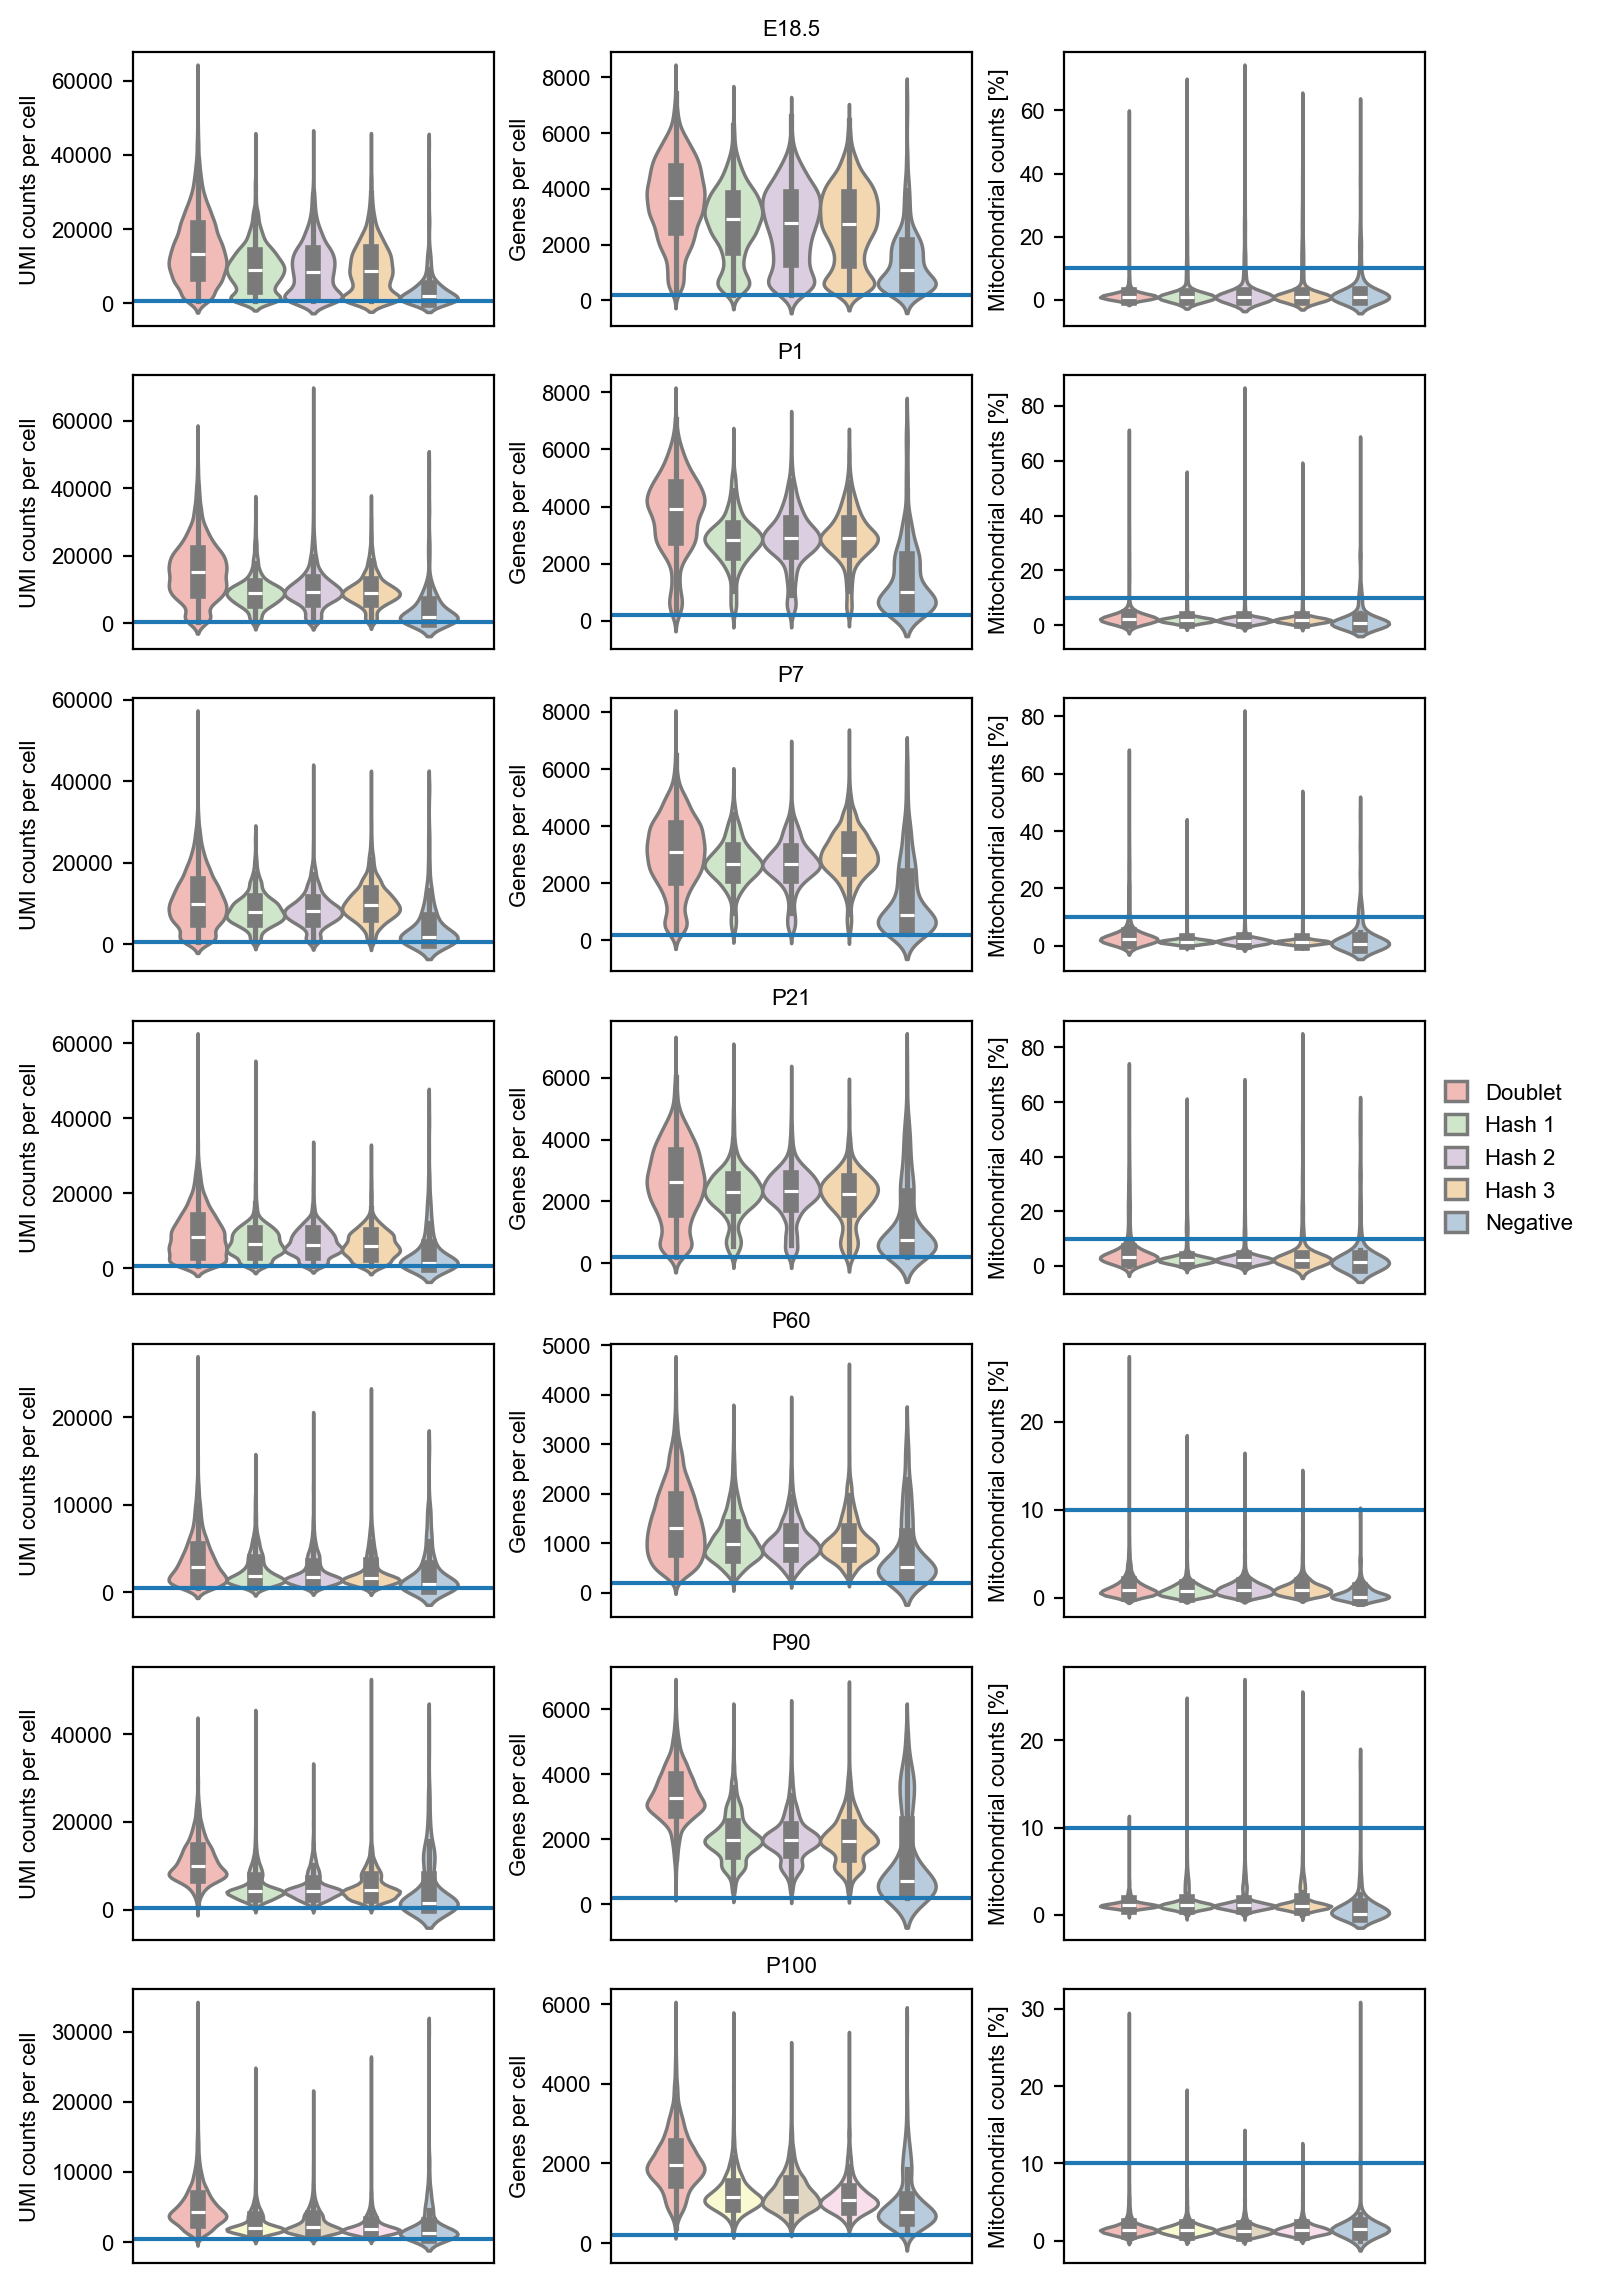

In [13]:
spf_datasets = [
    "spf_e185",
    "spf_p1",
    "spf_p7",
    "spf_p21",
    "spf_p60",
    "spf_p90",
    "wildling_spf_p100",
]

ncol = 3
nrow = len(spf_datasets)
fig_height = 287.042/25.4
fig_width = 200.493/25.4

qc_vars = ["total_counts", "n_genes_by_counts", "pct_counts_mt"]

fig, axes = plt.subplots(
    ncols=ncol,
    nrows=nrow,
    figsize=(
        fig_width,
        fig_height
    ),
    dpi=200,
    layout="constrained",
)

axes = axes.flatten()

i = 0
for ds in spf_datasets:
    if ds == "wildling_spf_p100":
        df_qc = sc.get.obs_df(
            all_datasets_unfiltered[ds][
                ~all_datasets_unfiltered[ds].obs["Classification"].isin(hto_list[0:3])
            ],
            keys=["Classification"] + qc_vars,
        )
        title = "P100"
    elif not ds.endswith("e185") and not ds.endswith("p90"):
        df_qc = sc.get.obs_df(
            all_datasets_unfiltered[ds][
                ~all_datasets_unfiltered[ds].obs["Classification"].isin(hto_list_old[3:7])
            ],
            keys=["Classification"] + qc_vars,
        )
        title = ds.removeprefix("spf_").upper()
    else:
        df_qc = sc.get.obs_df(
            all_datasets_unfiltered[ds][
                ~all_datasets_unfiltered[ds].obs["Classification"].isin(hto_list[3:7])
            ],
            keys=["Classification"] + qc_vars,
        )
        if ds == "spf_e185":
            title = "E18.5"
        else:
            title = "P90"

    df_qc["Classification"] = df_qc["Classification"].astype("category")
    df_qc["Classification"] = df_qc["Classification"].cat.reorder_categories(
        sorted(df_qc["Classification"].cat.categories), ordered=True
    )

    for var in qc_vars:
        sns.violinplot(
            df_qc, y=var, hue="Classification", ax=axes[i], palette=colors_combined
        )

        if var == "pct_counts_mt":
            axes[i].axhline(10)
            axes[i].set_ylabel("Mitochondrial counts [%]")
        elif var == "n_genes_by_counts":
            axes[i].set_title(title)
            axes[i].set_ylabel("Genes per cell")
            axes[i].axhline(200)
        elif var == "total_counts":
            axes[i].axhline(500)
            axes[i].set_ylabel("UMI counts per cell")
        
        axes[i].set_xticks([])

        # if handles is None:
        #     handles, labels = axes[i].get_legend_handles_labels()
        if i != 11:
            axes[i].get_legend().set_visible(False)
        else:
            handles, labels = axes[i].get_legend_handles_labels()
            labels = ['Doublet', 'Hash 1', 'Hash 2', 'Hash 3', 'Negative']
            axes[i].legend(handles = handles,labels = labels,bbox_to_anchor=(1, 0.5), loc="center left", frameon=False, handleheight=1, handlelength=1)

        i += 1

# plt.savefig(
#     '/figures/supplementary_2/violin_qc.svg',
# )

## Only germfree

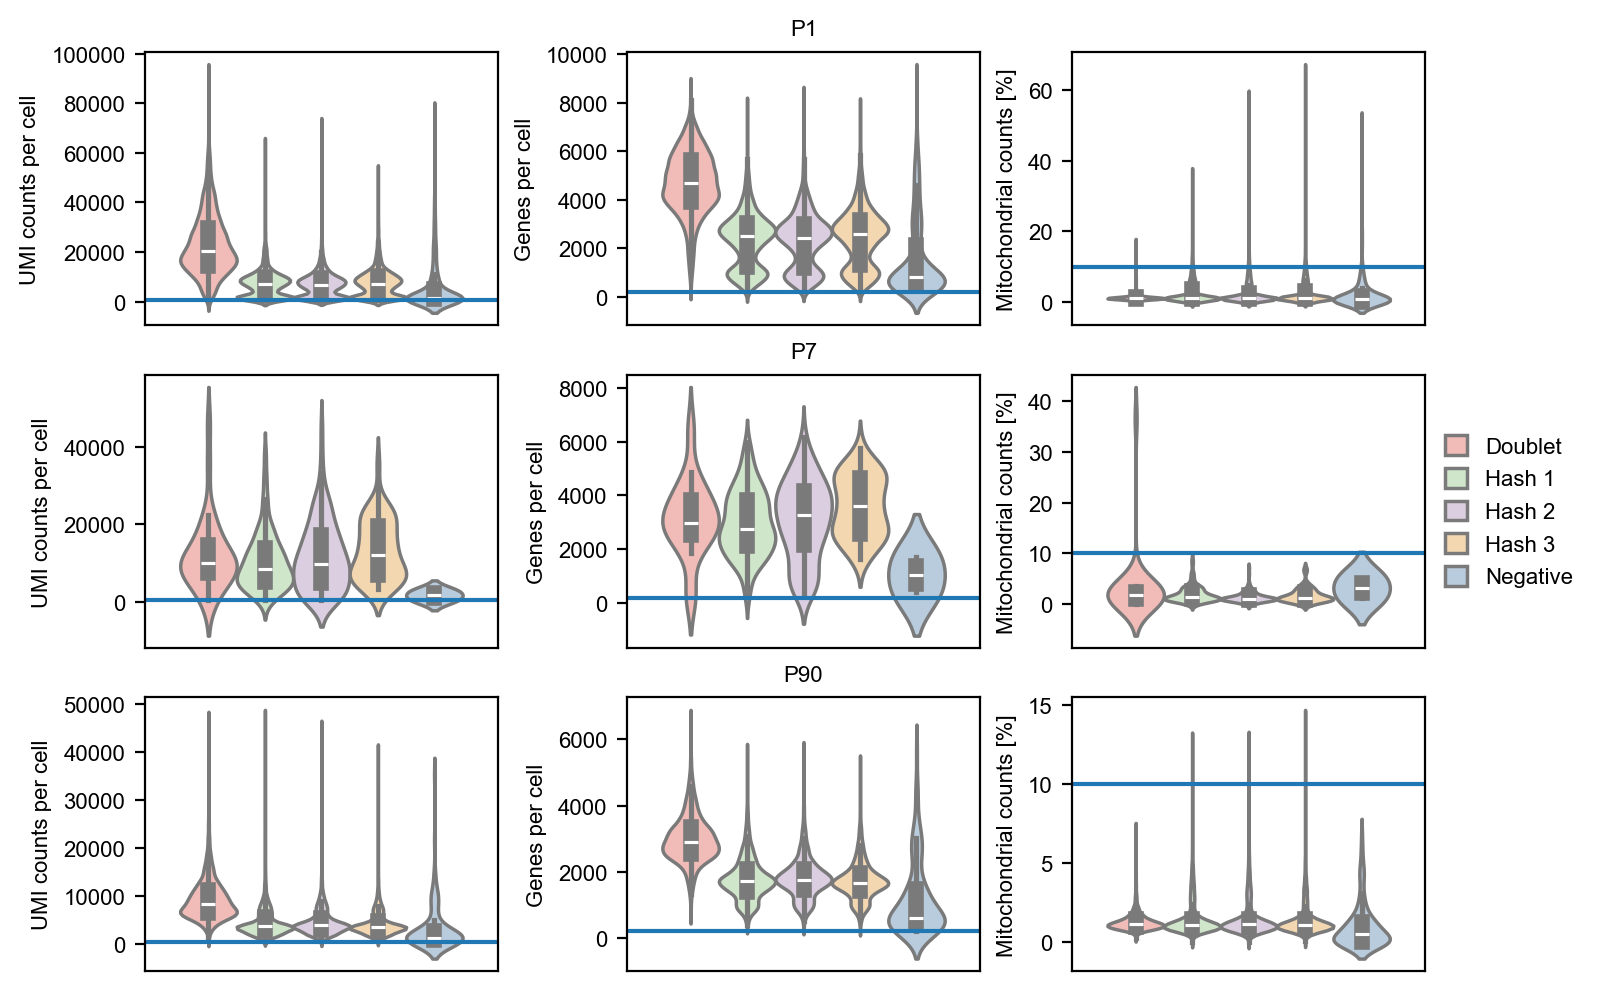

In [14]:
germfree_datasets = [
    "germfree_p1",
    "germfree_p7",
    "germfree_p90"
]

ncol = 3
nrow = len(germfree_datasets)
fig_height = 123.018/25.4
fig_width = 200.493/25.4

qc_vars = ["total_counts", "n_genes_by_counts", "pct_counts_mt"]

fig, axes = plt.subplots(
    ncols=ncol,
    nrows=nrow,
    figsize=(
        fig_width,
        fig_height
    ),
    dpi=200,
    layout="constrained",
)

axes = axes.flatten()

i = 0
for ds in germfree_datasets:
    df_qc = sc.get.obs_df(
        all_datasets_unfiltered[ds],
        keys=["Classification"] + qc_vars,
    )
    title = ds.removeprefix("germfree_").upper()

    df_qc["Classification"] = df_qc["Classification"].astype("category")
    df_qc["Classification"] = df_qc["Classification"].cat.reorder_categories(
        sorted(df_qc["Classification"].cat.categories), ordered=True
    )

    for var in qc_vars:
        sns.violinplot(
            df_qc, y=var, hue="Classification", ax=axes[i], palette=colors_combined
        )

        if var == "pct_counts_mt":
            axes[i].axhline(10)
            axes[i].set_ylabel("Mitochondrial counts [%]")
        elif var == "n_genes_by_counts":
            axes[i].set_title(title)
            axes[i].set_ylabel("Genes per cell")
            axes[i].axhline(200)
        elif var == "total_counts":
            axes[i].axhline(500)
            axes[i].set_ylabel("UMI counts per cell")
        
        axes[i].set_xticks([])

        # if handles is None:
        #     handles, labels = axes[i].get_legend_handles_labels()
        if i != 5:
            axes[i].get_legend().set_visible(False)
        else:
            handles, labels = axes[i].get_legend_handles_labels()
            labels = ['Doublet', 'Hash 1', 'Hash 2', 'Hash 3', 'Negative']
            axes[i].legend(handles = handles,labels = labels,bbox_to_anchor=(1, 0.5), loc="center left", frameon=False, handleheight=1, handlelength=1)

        i += 1

# plt.savefig(
#     '/figures/supplementary_6/violin_qc_germfree.svg',
# )

## Only Wildling

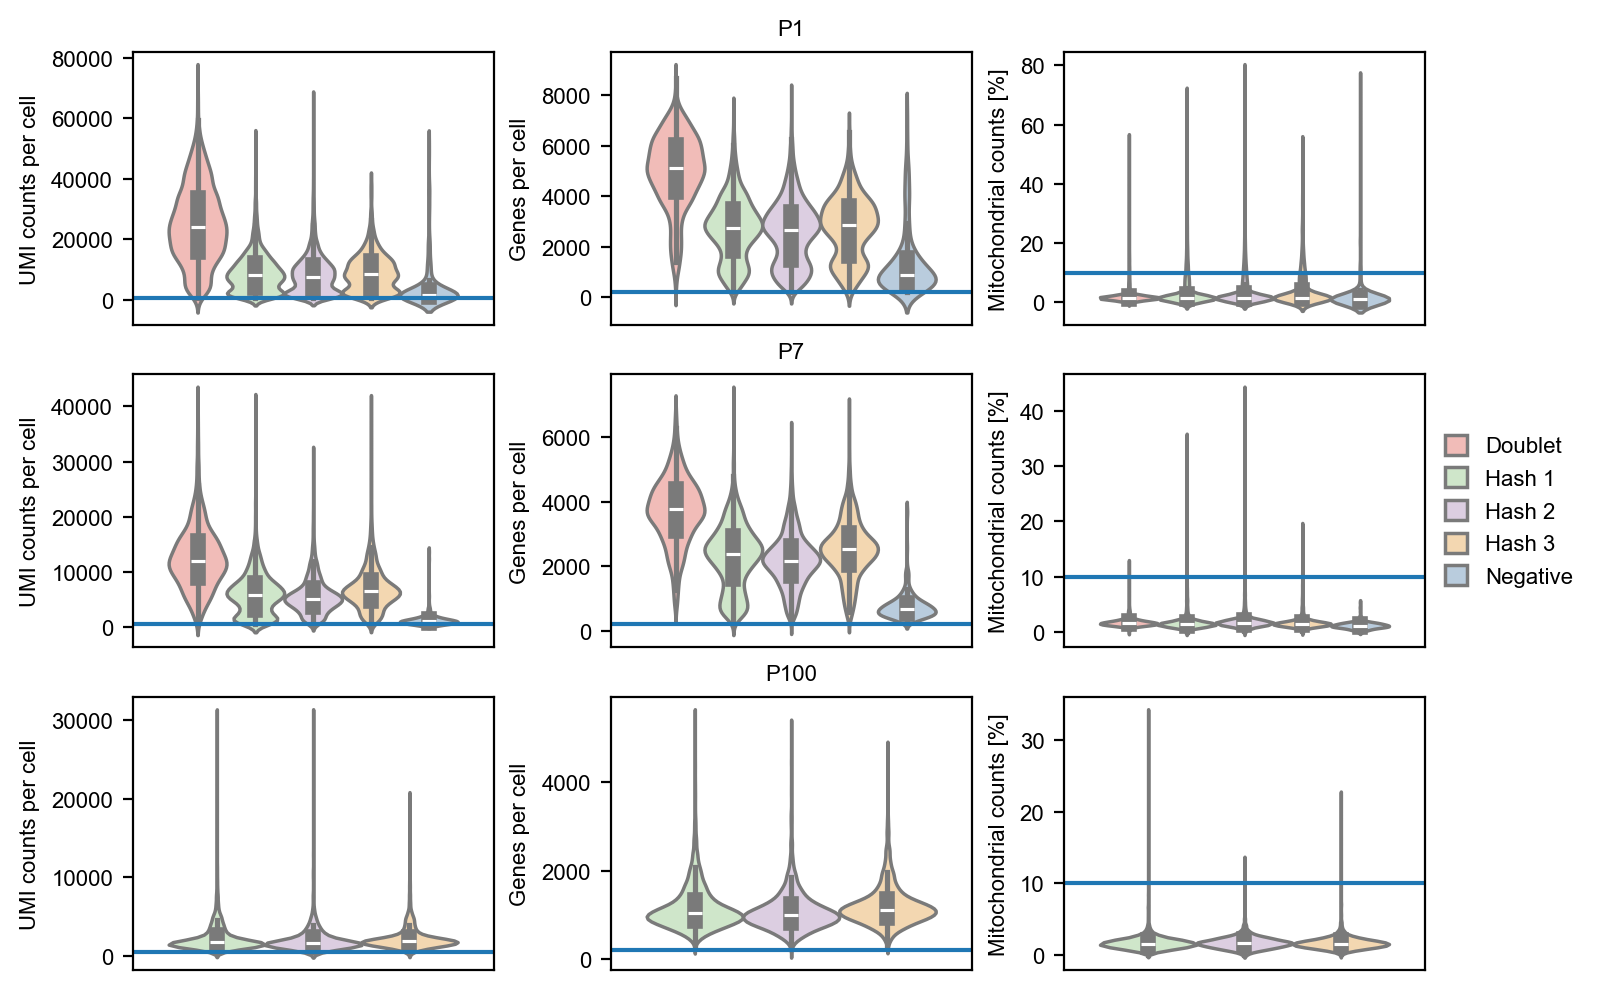

In [15]:
wildling_datasets = [
    "wildling_p1",
    "wildling_p7",
    "wildling_spf_p100",
]

ncol = 3
nrow = len(wildling_datasets)
fig_height = 123.018/25.4
fig_width = 200.493/25.4

qc_vars = ["total_counts", "n_genes_by_counts", "pct_counts_mt"]

fig, axes = plt.subplots(
    ncols=ncol,
    nrows=nrow,
    figsize=(
        fig_width,
        fig_height
    ),
    dpi=200,
    layout="constrained",
)

axes = axes.flatten()

i = 0
for ds in wildling_datasets:
    if ds == "wildling_spf_p100":
        df_qc = sc.get.obs_df(
            all_datasets_unfiltered[ds][
                all_datasets_unfiltered[ds].obs["Classification"].isin(hto_list[0:3])
            ],
            keys=["Classification"] + qc_vars,
        )
        title = "P100"
    else:
        df_qc = sc.get.obs_df(
            all_datasets_unfiltered[ds],
            keys=["Classification"] + qc_vars,
        )
        title = ds.removeprefix("wildling_").upper()

    df_qc["Classification"] = df_qc["Classification"].astype("category")
    df_qc["Classification"] = df_qc["Classification"].cat.reorder_categories(
        sorted(df_qc["Classification"].cat.categories), ordered=True
    )
    if ds == 'wildling_p7':
            palette = {
            'Doublet': '#fbb4ae',
            'Negative': '#b3cde3',
            'Hashtag_2': '#ccebc5',
            'Hashtag_3': '#decbe4',
            'Hashtag_4': '#fed9a6',
        }
    else:
            palette = {
            'Doublet': '#fbb4ae',
            'Negative': '#b3cde3',
            'Hashtag_1': '#ccebc5',
            'Hashtag_2': '#decbe4',
            'Hashtag_3': '#fed9a6',
        }

    for var in qc_vars:

        sns.violinplot(
            df_qc, y=var, hue="Classification", ax=axes[i], palette=palette
        )

        if var == "pct_counts_mt":
            axes[i].axhline(10)
            axes[i].set_ylabel("Mitochondrial counts [%]")
        elif var == "n_genes_by_counts":
            axes[i].set_title(title)
            axes[i].set_ylabel("Genes per cell")
            axes[i].axhline(200)
        elif var == "total_counts":
            axes[i].axhline(500)
            axes[i].set_ylabel("UMI counts per cell")
        
        axes[i].set_xticks([])

        # if handles is None:
        #     handles, labels = axes[i].get_legend_handles_labels()
        if i != 5:
            axes[i].get_legend().set_visible(False)
        else:
            handles, labels = axes[i].get_legend_handles_labels()
            labels = ['Doublet', 'Hash 1', 'Hash 2', 'Hash 3', 'Negative']
            axes[i].legend(handles = handles,labels = labels,bbox_to_anchor=(1, 0.5), loc="center left", frameon=False, handleheight=1, handlelength=1)

        i += 1

# plt.savefig(
#     '/figures/supplementary_6/violin_qc_wildling.svg',
# )